<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/A_Transformer_based_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

In [ ]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='pyth

In [ ]:
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [ ]:
movies

,movie_id,title,genres
0,movie_1,Toy Story (1995),Animation|Children's|Comedy
1,movie_2,Jumanji (1995),Adventure|Children's|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama
4,movie_5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,movie_3948,Meet the Parents (2000),Comedy
3879,movie_3949,Requiem for a Dream (2000),Drama
3880,movie_3950,Tigerland (2000),Drama
3881,movie_3951,Two Family House (2000),Drama


In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

In [ ]:
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)

In [ ]:
ratings_data

,user_id,movie_ids,ratings,timestamps
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_102...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[978300019, 978300055, 978300055, 978300055, 9..."
1,user_10,"[movie_597, movie_858, movie_743, movie_1210, ...","[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[978224375, 978224375, 978224375, 978224400, 9..."
2,user_100,"[movie_260, movie_1676, movie_1198, movie_541,...","[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0, ...","[977593595, 977593595, 977593607, 977593624, 9..."
3,user_1000,"[movie_971, movie_260, movie_2990, movie_2973,...","[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, 5.0, 5.0, ...","[975040566, 975040566, 975040566, 975040629, 9..."
4,user_1001,"[movie_1198, movie_1617, movie_2885, movie_390...","[4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 4.0, 5.0, 5.0, ...","[975039591, 975039702, 975039702, 975039898, 9..."
...,...,...,...,...
6035,user_995,"[movie_1894, movie_260, movie_247, movie_433, ...","[2.0, 4.0, 5.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, ...","[975054785, 975054785, 975054785, 975054853, 9..."
6036,user_996,"[movie_1347, movie_2146, movie_1961, movie_274...","[4.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, ...","[975052132, 975052132, 975052195, 975052284, 9..."
6037,user_997,"[movie_1196, movie_2082, movie_3247, movie_244...","[4.0, 3.0, 3.0, 3.0, 2.0, 5.0, 5.0, 5.0, 4.0, ...","[975044235, 975044425, 975044426, 975044426, 9..."
6038,user_998,"[movie_2266, movie_1264, movie_1097, movie_164...","[3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, ...","[975043499, 975043593, 975043593, 975043593, 9..."


In [ ]:
equence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

In [ ]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [ ]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

In [ ]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

In [ ]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

In [ ]:
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)


In [ ]:
next(iter(train_dataset))

(OrderedDict([('user_id', <tf.Tensor: shape=(265,), dtype=string, numpy=
               array([b'user_1079', b'user_1071', b'user_11', b'user_1112', b'user_1042',
                      b'user_1017', b'user_1068', b'user_1116', b'user_1084',
                      b'user_102', b'user_1001', b'user_1093', b'user_1062',
                      b'user_1013', b'user_1112', b'user_1051', b'user_1029',
                      b'user_1010', b'user_1069', b'user_1088', b'user_1020',
                      b'user_1099', b'user_1086', b'user_1088', b'user_1017',
                      b'user_1019', b'user_1105', b'user_1114', b'user_1089',
                      b'user_1101', b'user_1106', b'user_1107', b'user_1086',
                      b'user_1015', b'user_1117', b'user_1019', b'user_1101',
                      b'user_1010', b'user_1094', b'user_1101', b'user_1015',
                      b'user_1059', b'user_1102', b'user_1010', b'user_1022',
                      b'user_1047', b'user_1018', b'user_1

In [ ]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

In [ ]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features

In [ ]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_movie_ids (InputLayer) [(None, 3)]          0                                            
__________________________________________________________________________________________________
movie_index_lookup (StringLooku multiple             0           target_movie_id[0][0]            
                                                                 sequence_movie_ids[0][0]         
__________________________________________________________________________________________________
movie_embedding (Embedding)     multiple             240746      movie_index_lookup[0][0]         
                                                                 movie_index_lookup[1][0]         
______________________________________________________________________________________________

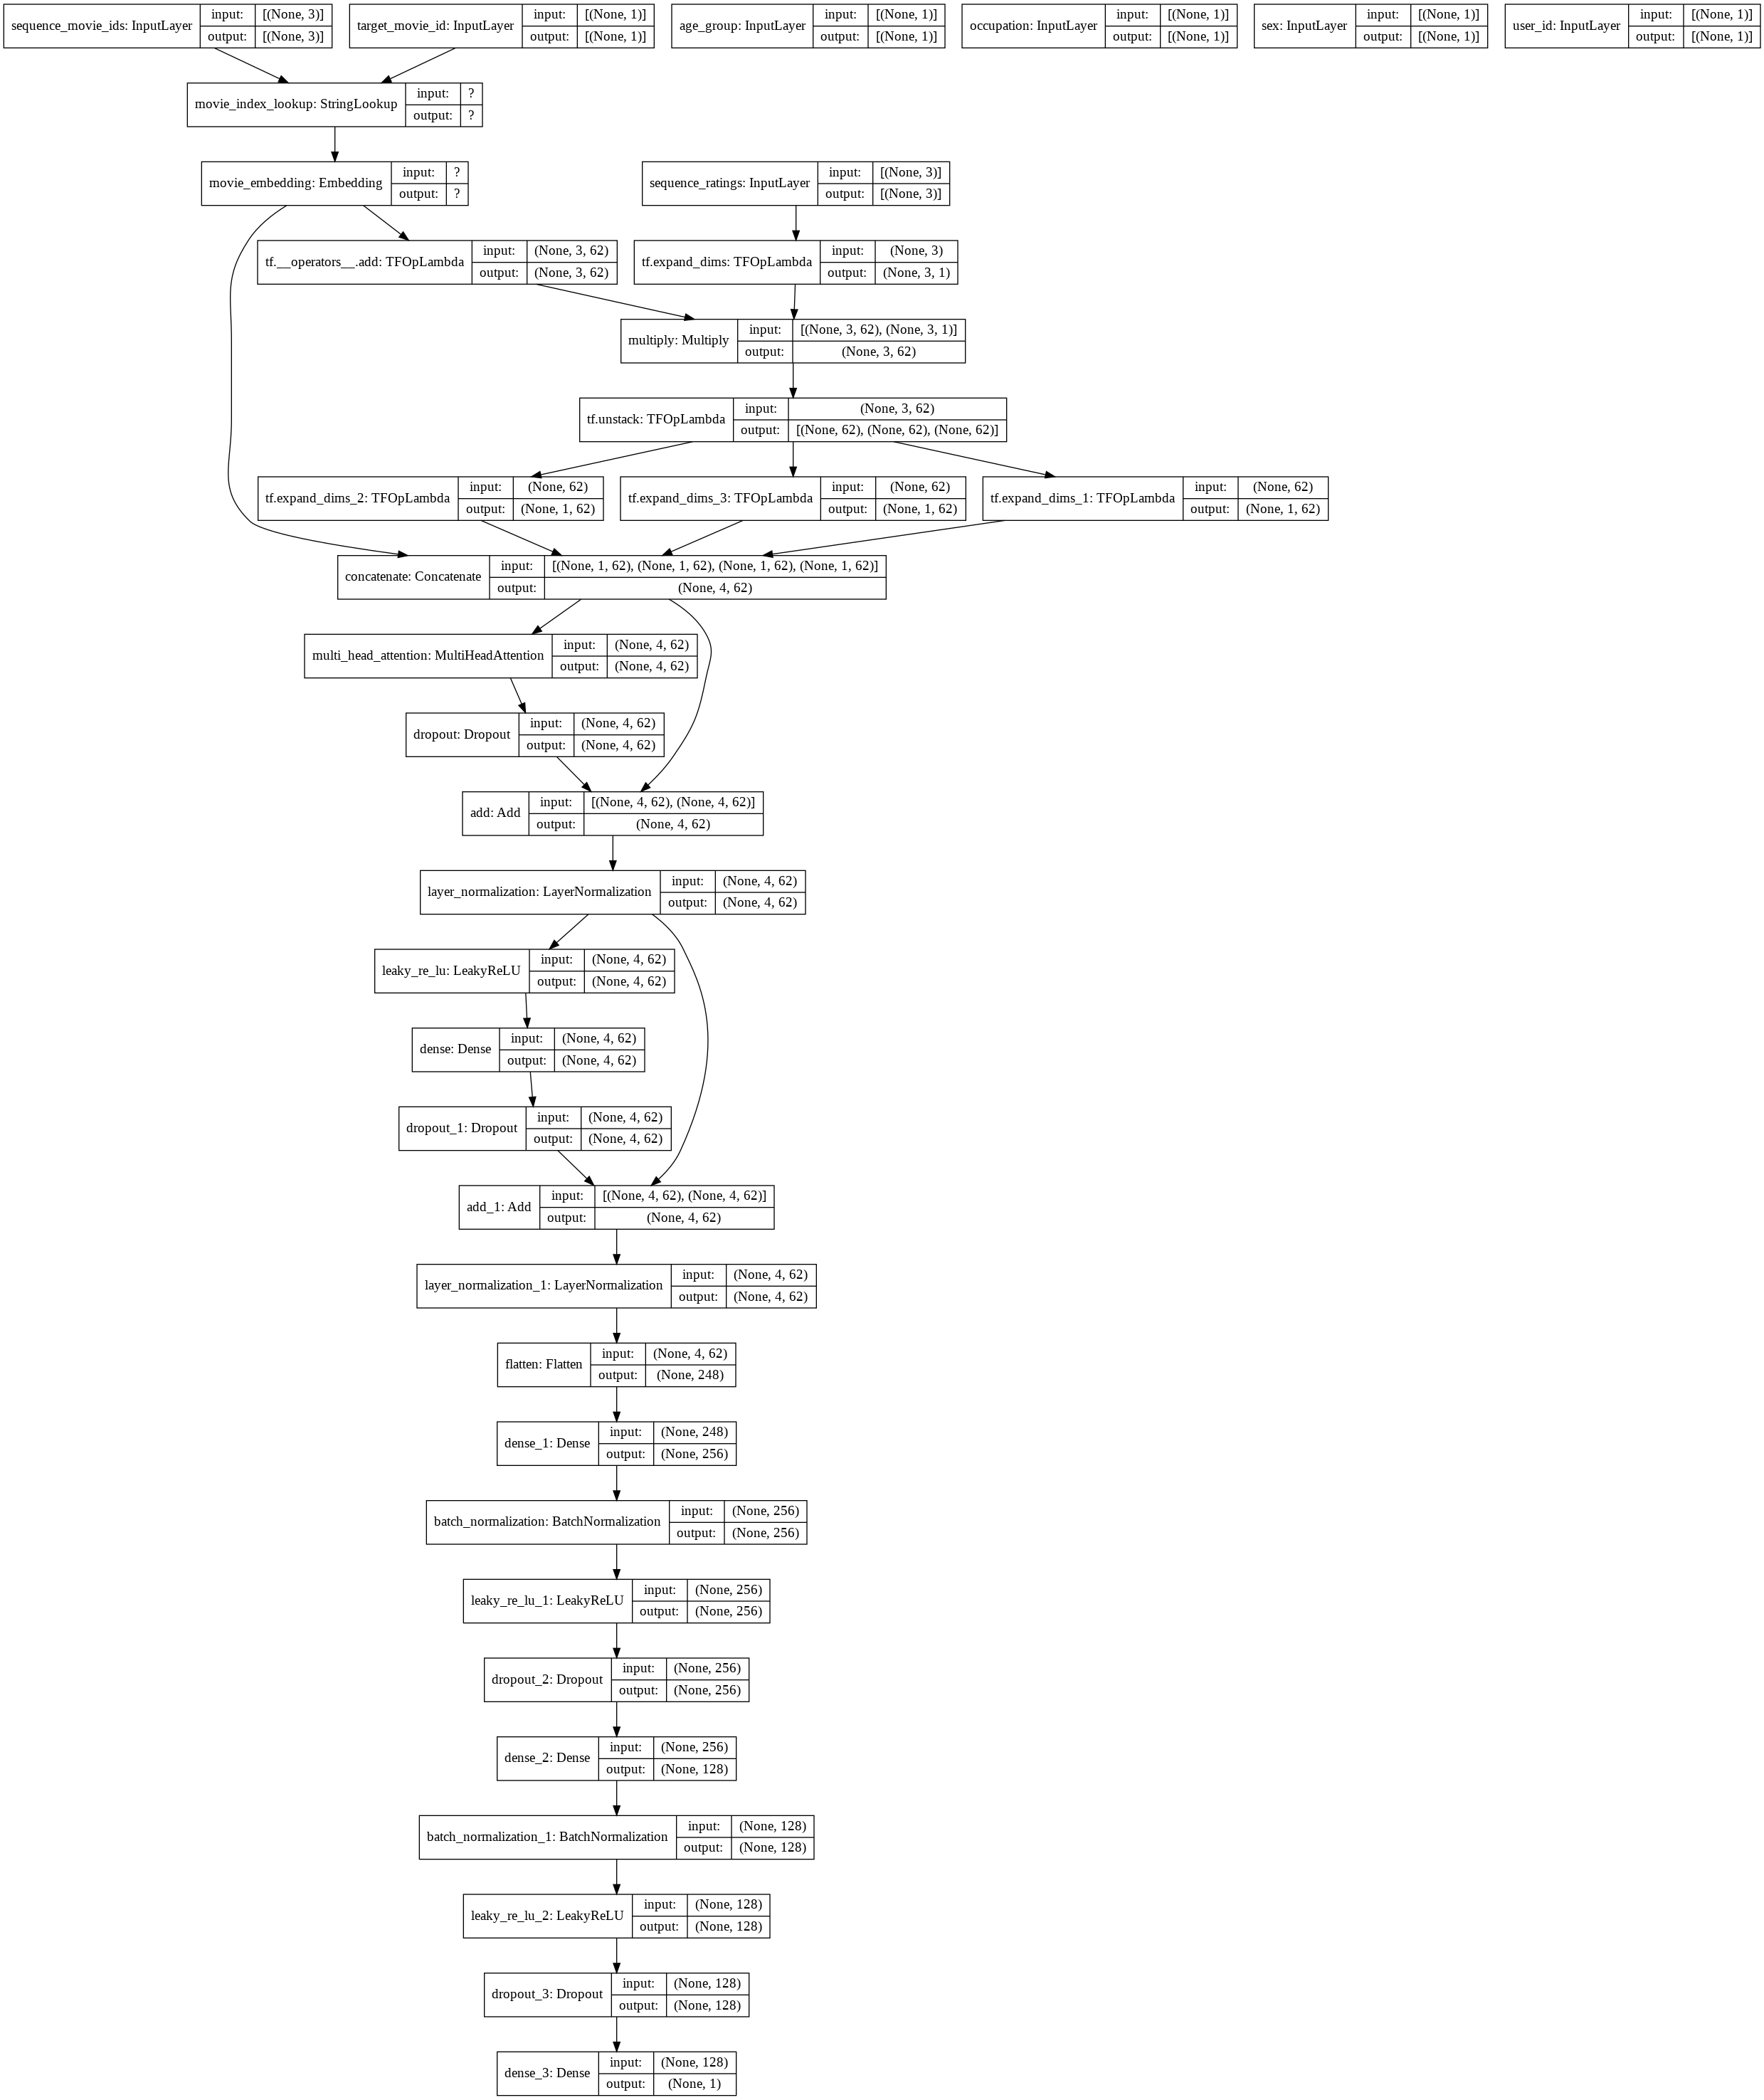

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
model.fit(train_dataset, epochs=5)

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

Epoch 1/5
1599/1599 [==============================] - 44s 26ms/step - loss: 1.5915 - mean_absolute_error: 0.9838
Epoch 2/5
1599/1599 [==============================] - 42s 26ms/step - loss: 1.0301 - mean_absolute_error: 0.8108
Epoch 3/5
1599/1599 [==============================] - 43s 27ms/step - loss: 0.9663 - mean_absolute_error: 0.7838
Epoch 4/5
1599/1599 [==============================] - 42s 26ms/step - loss: 0.9302 - mean_absolute_error: 0.7681
Epoch 5/5
1599/1599 [==============================] - 42s 26ms/step - loss: 0.9118 - mean_absolute_error: 0.7608
Test MAE: 0.762
